# Numerical Optimization and Large Scale Linear Algebra
## Assignment 2 - Constrained Least Squares
### Instructor: P. Vassalos

**Student:** Phevos A. Margonis - f3352317

**Date:** 26/Feb/2024

---

The goal of this exercise is to optimize the lighting in a specific area using a set of lamps. The area is divided into small regions, called pixels, and each region's lighting level is determined by the power of the lamps illuminating it.


In [1]:
# !pip install cvxpy
# !pip install pyswarms
import os
import time
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pyswarms as ps
from pyswarms.single import LocalBestPSO
from scipy.spatial.distance import cdist
from tqdm import tqdm
import random

In [2]:
# Constants
M = 625
N = 10

In [3]:
# Define lamp positions and heights
lamp_positions = np.array([
    (4.1, 20.4, 4),
    (14.1, 21.3, 3.5),
    (22.6, 17.1, 6),
    (5.5, 12.3, 4),
    (12.2, 9.7, 4),
    (15.3, 13.8, 6),
    (21.3, 10.5, 5.5),
    (3.9, 3.3, 5),
    (13.1, 4.3, 5),
    (20.3, 4.2, 4.5)
])

In [4]:
# Generate grid of pixel positions
x = np.arange(0.5, 25.5, 1)
y = np.arange(0.5, 25.5, 1)
xx, yy = np.meshgrid(x, y, indexing='xy')
zz = np.zeros_like(xx)
# Combine xx, yy, zz into a single array of 3D positions
pixel_positions = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=-1)

In [5]:
# Calculate distance between every pixel-lamp combination
distances = cdist(pixel_positions, lamp_positions, metric='euclidean')
A = 1 / distances**2 # Illumination decay
# Scale A so that average illumination with all lamps at power 1 is 1
scaler = 1 / np.mean(np.sum(A, axis=1))
A = A * scaler

# Desired illumination
l_des = np.ones(M)

### Illumination pattern with the power of all lamps set to 1

In [6]:
p = np.ones(N)
l1 = A @ p # Illumination with power set to 1

rmse_all_ones = np.sqrt(np.mean((l1 - l_des)**2))
print(f" RMSE when power is set to 1 across all lamps: \n{rmse_all_ones}")

 RMSE when power is set to 1 across all lamps: 
0.24174131853807876


### Power distribution that minimizes the sum square deviation with a desired uniform illumination.

In [7]:

p_opt, residuals, rank, s = np.linalg.lstsq(A, l_des, rcond=None)
l_opt = A @ p_opt
rmse_p_opt = np.sqrt(np.mean((l_opt - l_des)**2))

print(f" Optimal powers:\n{p_opt}")
print(f" RMSE with optimized power: \n{rmse_p_opt}")

 Optimal powers:
[1.46211018 0.78797433 2.96641047 0.74358042 0.08317333 0.21263945
 0.21218408 2.05114815 0.90760315 1.47222464]
 RMSE with optimized power: 
0.1403904813427606


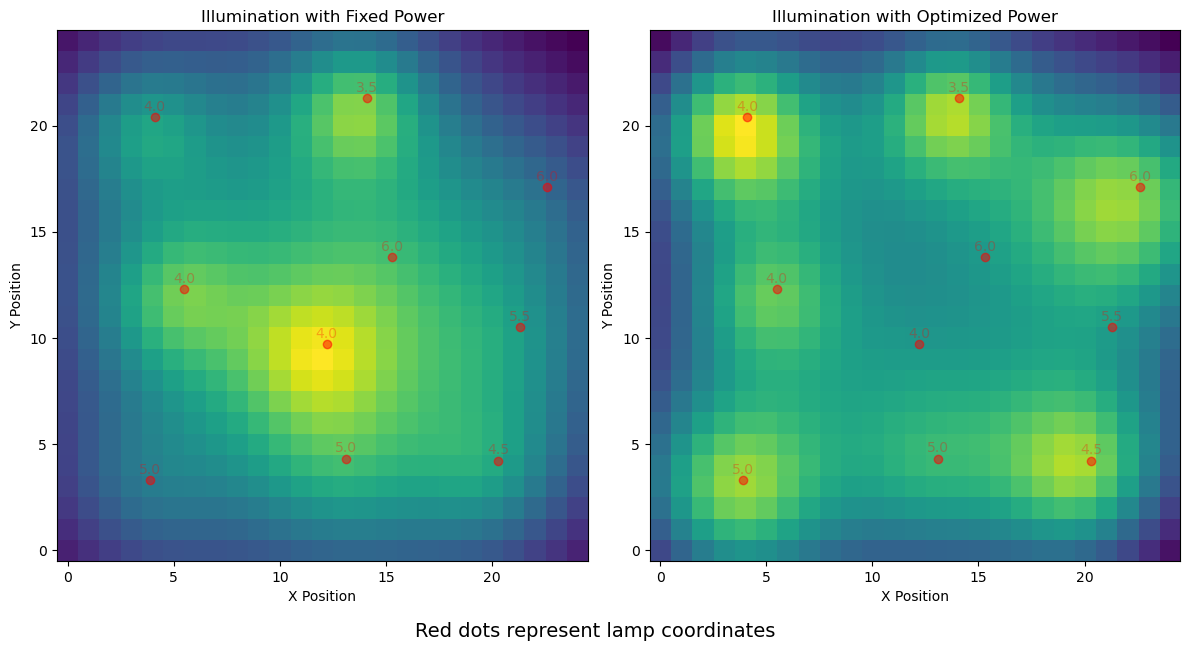

In [8]:
# Convert back to grid layout
l1_grid = l1.reshape(25, 25)
l_opt_grid = l_opt.reshape(25, 25)

# Create subplot layout
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for fixed power level at 1
cax1 = ax[0].imshow(l1_grid, cmap='viridis', origin='lower')
ax[0].scatter(lamp_positions[:, 0], lamp_positions[:, 1], c='red', marker='o', alpha=0.5, label='Lamp Positions')
ax[0].set_title('Illumination with Fixed Power')
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')

# Plot for optimized power levels
cax2 = ax[1].imshow(l_opt_grid, cmap='viridis', origin='lower')
ax[1].scatter(lamp_positions[:, 0], lamp_positions[:, 1], c='red', marker='o', alpha=0.5, label='Lamp Positions')
ax[1].set_title('Illumination with Optimized Power')
ax[1].set_xlabel('X Position')
ax[1].set_ylabel('Y Position')

for lamp_pos in lamp_positions:
    # For the plot with fixed power level
    ax[0].text(lamp_pos[0], lamp_pos[1]+0.5, str(lamp_pos[2]), color='red', alpha=0.3, ha='center', va='center')

    # For the plot with optimized power levels
    ax[1].text(lamp_pos[0], lamp_pos[1]+0.5, str(lamp_pos[2]), color='red', alpha=0.3, ha='center', va='center')

fig.text(0.5, -0.05, "Red dots represent lamp coordinates", ha='center', fontsize=14)
plt.tight_layout()
plt.show()

The plots above present the luminosity intensity across a 25 by 25 surface area. As seen in the plot on the left, with a constant lamp power level, luminosity peaks at a focal point near the center of the area and gradually fades outwards. In contrast, the plot on the right achieves a more even and smooth distribution of light.

### Histograms of patch illumination values for all lamp powers one, and for lamp powers found by LS.

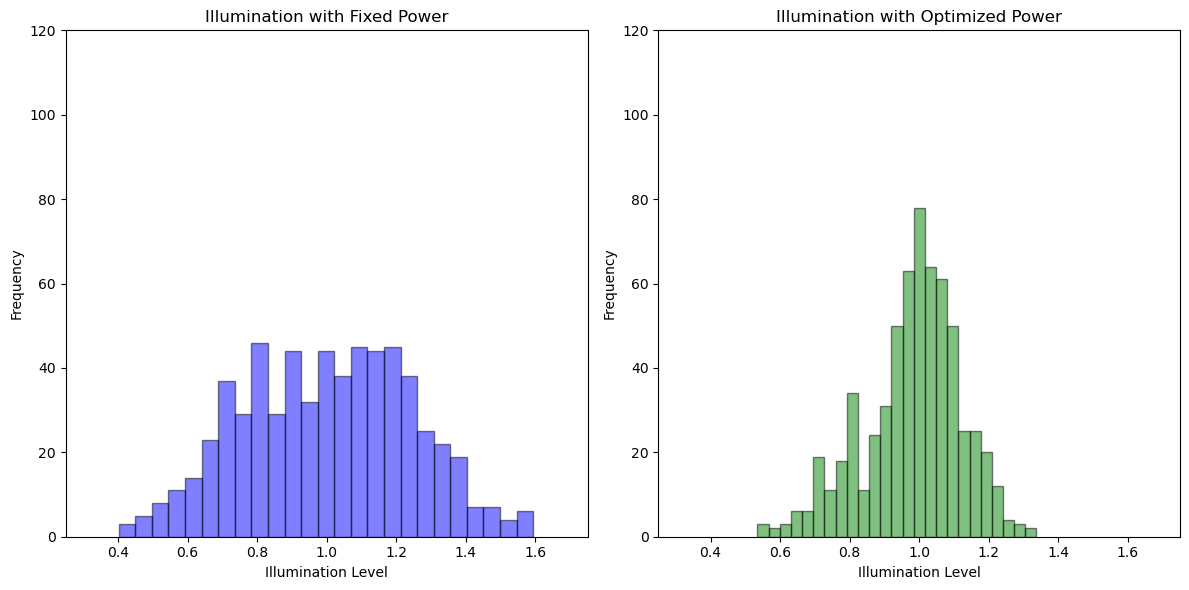

In [9]:
# Create subplot layout for histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for illumination values with all lamp powers set to one
ax[0].hist(l1, bins=25, color='blue', alpha=0.5, edgecolor='black')
ax[0].set_title('Illumination with Fixed Power')
ax[0].set_xlabel('Illumination Level')
ax[0].set_ylabel('Frequency')
ax[0].set_ylim(0, 120)
ax[0].set_xlim(0.25,1.75)

# Histogram for illumination values with optimized lamp powers
ax[1].hist(l_opt, bins=25, color='green', alpha=0.5, edgecolor='black')
ax[1].set_title('Illumination with Optimized Power')
ax[1].set_xlabel('Illumination Level')
ax[1].set_ylabel('Frequency')
ax[1].set_ylim(0, 120)
ax[1].set_xlim(0.25, 1.75)

plt.tight_layout()
plt.show()

As stated above, the goal of this exercise is to achieve even illumination (of $l=1$) across the area. This means that, in an ideal scenario, every pixel would have an illumination of 1. The histograms above compare how many pixels achieve that goal. Clearly, the optimized power using Least Squares is better, because there are more pixels with luminocity close to 1.

### Constrained Least Squares.
The total energy consumption of the lamps will be equal 10 and non of them can be negative.

In [10]:
# Formulate the problem
p_new       = cp.Variable(N) # Initialize target variable
objective   = cp.Minimize(cp.norm(A @ p_new - l_des, 2)) # Objective Function to Minimize
constraints = [
    cp.sum(p_new) == 10,  # Total power consumption equals 10
    p_new >= 0,  # Non-negative power levels
]

problem = cp.Problem(objective, constraints) # Instantiate the problem
problem.solve() # Solve the problem

# Checks
p_new = p_new.value
sumIs10 = (sum(p_new).round(10)==10)
isNonNegative = ( np.any(p_new) > 0 )

if sumIs10 and isNonNegative and problem.status not in ["infeasible", "unbounded"]:
    print("Problem solved succesfully and the constraints are met.")
    print(f"New power levels:\n{ p_new }")
else:
    print("The problem was not successfully solved. Status:", problem.status)

Problem solved succesfully and the constraints are met.
New power levels:
[1.33953101e+00 8.94268233e-01 2.36804969e+00 7.79206452e-01
 3.18872716e-01 1.28488092e-09 3.95132078e-01 1.76365169e+00
 7.60421804e-01 1.38086632e+00]


c:\Users\Foivos\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


 RMSE with constrained power: 
0.1557603732869524


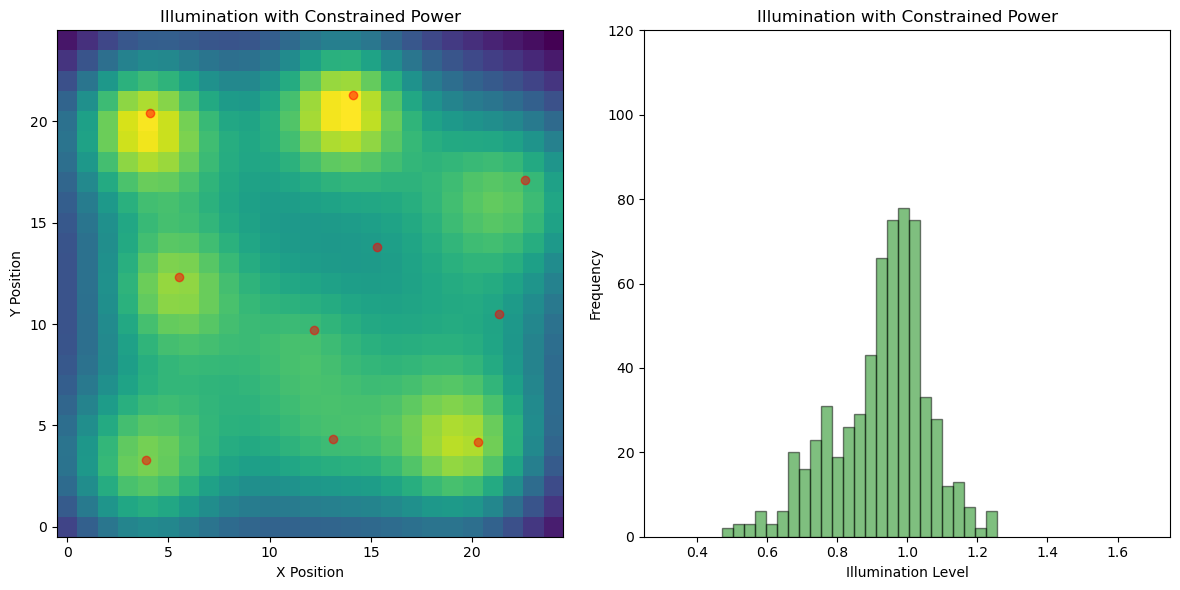

In [11]:
# New luminocity and RMSE
l_new = A @ p_new
rmse_p_new = np.sqrt(np.mean((l_new - l_des)**2))
print(f" RMSE with constrained power: \n{rmse_p_new}")

# Prepare luminocity for plot
l_new_grid = l_new.reshape(25, 25)

# Create subplot layout
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for fixed power level at 1
cax1 = ax[0].imshow(l_new_grid, cmap='viridis', origin='lower')
ax[0].scatter(lamp_positions[:, 0], lamp_positions[:, 1], c='red', marker='o', alpha=0.5, label='Lamp Positions')
ax[0].set_title('Illumination with Constrained Power')
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')

# Histogram for illumination values with optimized lamp powers
ax[1].hist(l_new, bins=25, color='green', alpha=0.5, edgecolor='black')
ax[1].set_title('Illumination with Constrained Power')
ax[1].set_xlabel('Illumination Level')
ax[1].set_ylabel('Frequency')
ax[1].set_ylim(0, 120)
ax[1].set_xlim(0.25, 1.75)

plt.tight_layout()
plt.show()

Since this result is from a constrained optimization, the RMSE is worse than that of the unconstrained optimization. The histogram above shows that the new power settings have increased the skewness of the distribution towards the left, thus introducing darker spots.

## Challenge

Try to find, new points for the lamps to beat the RMS error
of the first question. The lamps can be in any height between 4 and 6
meters and of course inside the area. Again, the total energy of the lamps
should be 10 and non of them should be negative. Run different -random-
choices of positions until you find a better solution. For this choice of
points, present the colormap picture of the illumination as well as
the histogram of the intensities of the pixels of the area.

---

The algorithm chosen to explore the search space for the new lamp positions is the Local-Best variation of **Particle Swarm Optimization**. This version of PSO focuses on the performance of neighboring particles to guide each particle's movement towards the optimal solution. One of its main advantages is the ability to prevent premature convergence on suboptimal solutions, promoting a more thorough exploration of the search space. Additionally, Local-Best PSO can be more adaptable to complex landscapes, as it leverages local information to navigate towards the global optimum."

In [12]:
def objective_function(lamp_positions_swarm):
    global pixel_positions, l_des
    rms_errors = []

    for lamp_positions in lamp_positions_swarm:  # Loop over each particle
        lamp_positions = lamp_positions.reshape(N, 3)  # Reshape to N x 3 for N lamps

        # Calculate distances and A matrix as before
        distances = cdist(pixel_positions, lamp_positions, metric='euclidean')
        A = 1 / distances**2
        scaler = 1 / np.mean(np.sum(A, axis=1))
        A_scaled = A * scaler

        # Solve for optimal lamp powers with cvxpy
        p_new = cp.Variable(N)
        objective = cp.Minimize(cp.norm(A_scaled @ p_new - l_des, 2))
        constraints = [cp.sum(p_new) == 10, p_new >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve()

        if problem.status not in ["infeasible", "unbounded"]:
            # Compute RMS error for this configuration
            l_new = A_scaled @ p_new.value
            rms_error = np.sqrt(np.mean((l_new - l_des)**2))
            rms_errors.append(rms_error)
        else:
            # Assign a high error if the problem is infeasible or unbounded
            rms_errors.append(np.inf)

    return np.array(rms_errors)

# Define the bounds for the swarm initialization
bounds = (np.array([0.5, 0.5, 4] * N), np.array([24.5, 24.5, 6] * N))

In [15]:
# Define lists of possible alternatives for each option (Random-Search)
c1_options = [0.3, 0.4, 0.5, 0.6]
c2_options = [0.3, 0.4, 0.5, 0.6]
w_options = [0.3, 0.5, 0.7, 0.8, 0.9]
k_options = [10, 25, 50]

for i in range(5):

    print(f"{i:=^80}")

    # Set-up hyperparameters
    options = {'c1': random.choice(c1_options),
               'c2': random.choice(c2_options),
               'w': random.choice(w_options),
               'k': random.choice(k_options),
               'p': 2}

    # Initialize positions
    init_positions = np.random.uniform(low=bounds[0], high=bounds[1], size=(150, N*3))

     # If file exists, load the previously saved best positions
    if os.path.exists('lamp_positions_and_cost.npz'):
        data = np.load('lamp_positions_and_cost.npz')
        saved_cost = data['cost']
        # Directly use the saved positions if they exist
        init_positions[0] = data['positions']  # Assuming the shape is compatible



    optimizer = ps.single.LocalBestPSO(n_particles=150,
                                       dimensions=N*3,
                                       options=options,
                                       bounds=bounds,
                                       init_pos=init_positions
                                       )


    # Run the optimization
    cost, pos = optimizer.optimize(objective_function, iters=100)

    # Save new positions and cost if they are better or if the file doesn't exist
    if not os.path.exists('lamp_positions_and_cost.npz') or cost < saved_cost:
        np.savez('lamp_positions_and_cost.npz', positions=pos, cost=cost, options=options)
        print("New positions and cost saved.")
    else:
        print("Existing positions and cost are better.")

2024-02-26 23:13:38,772 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.5, 'w': 0.3, 'k': 50, 'p': 2}


=======================================0========================================


pyswarms.single.local_best:   0%|          |0/100

pyswarms.single.local_best: 100%|██████████|100/100, best_cost=0.054
2024-02-26 23:17:43,037 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.05400591922086317, best pos: [21.02284035 14.00687596  5.78893109  3.99118105  5.10815402  5.71853298
  9.48972347 13.22930121  5.74307463  0.57046539 13.58241357  4.86932679
 12.14587218 24.01641349  5.49719469 23.72686196 23.05826424  5.19619916
  2.35781534  1.83949865  5.53801433  2.04990658 22.94338313  4.16914542
 11.73409728  2.30672973  5.95385993 22.67297619  2.84263178  4.86348037]
2024-02-26 23:17:43,052 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.3, 'w': 0.3, 'k': 10, 'p': 2}


New positions and cost saved.
=======================================1========================================


pyswarms.single.local_best: 100%|██████████|100/100, best_cost=0.0535
2024-02-26 23:21:58,078 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.053512688794982735, best pos: [21.03440729 14.02633632  5.89667239  3.98949947  5.10103007  5.74669895
  9.48764543 13.22741663  5.76298442  0.57265287 13.58967655  4.87951017
 12.17409745 24.06079175  5.49712525 23.72807873 23.05620699  5.20147208
  2.37563011  1.8104864   5.53709594  2.06792547 22.93685779  4.16354119
 11.76708785  2.29915237  5.95290567 22.67220418  2.84038808  4.85181048]
2024-02-26 23:21:58,099 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.7, 'k': 50, 'p': 2}


New positions and cost saved.
=======================================2========================================


pyswarms.single.local_best: 100%|██████████|100/100, best_cost=0.0535
2024-02-26 23:26:13,891 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.053512688794982735, best pos: [21.03440729 14.02633632  5.89667239  3.98949947  5.10103007  5.74669895
  9.48764543 13.22741663  5.76298442  0.57265287 13.58967655  4.87951017
 12.17409745 24.06079175  5.49712525 23.72807873 23.05620699  5.20147208
  2.37563011  1.8104864   5.53709594  2.06792547 22.93685779  4.16354119
 11.76708785  2.29915237  5.95290567 22.67220418  2.84038808  4.85181048]
2024-02-26 23:26:13,904 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.5, 'w': 0.8, 'k': 50, 'p': 2}


Existing positions and cost are better.
=======================================3========================================


pyswarms.single.local_best: 100%|██████████|100/100, best_cost=0.0535
2024-02-26 23:30:27,897 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.053512688794982735, best pos: [21.03440729 14.02633632  5.89667239  3.98949947  5.10103007  5.74669895
  9.48764543 13.22741663  5.76298442  0.57265287 13.58967655  4.87951017
 12.17409745 24.06079175  5.49712525 23.72807873 23.05620699  5.20147208
  2.37563011  1.8104864   5.53709594  2.06792547 22.93685779  4.16354119
 11.76708785  2.29915237  5.95290567 22.67220418  2.84038808  4.85181048]
2024-02-26 23:30:27,916 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 0.3, 'c2': 0.4, 'w': 0.7, 'k': 10, 'p': 2}


Existing positions and cost are better.
=======================================4========================================


pyswarms.single.local_best: 100%|██████████|100/100, best_cost=0.0535
2024-02-26 23:34:49,006 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.053512688794982735, best pos: [21.03440729 14.02633632  5.89667239  3.98949947  5.10103007  5.74669895
  9.48764543 13.22741663  5.76298442  0.57265287 13.58967655  4.87951017
 12.17409745 24.06079175  5.49712525 23.72807873 23.05620699  5.20147208
  2.37563011  1.8104864   5.53709594  2.06792547 22.93685779  4.16354119
 11.76708785  2.29915237  5.95290567 22.67220418  2.84038808  4.85181048]


Existing positions and cost are better.


 RMSE with optimized lamp positions: 
0.053512688794982735


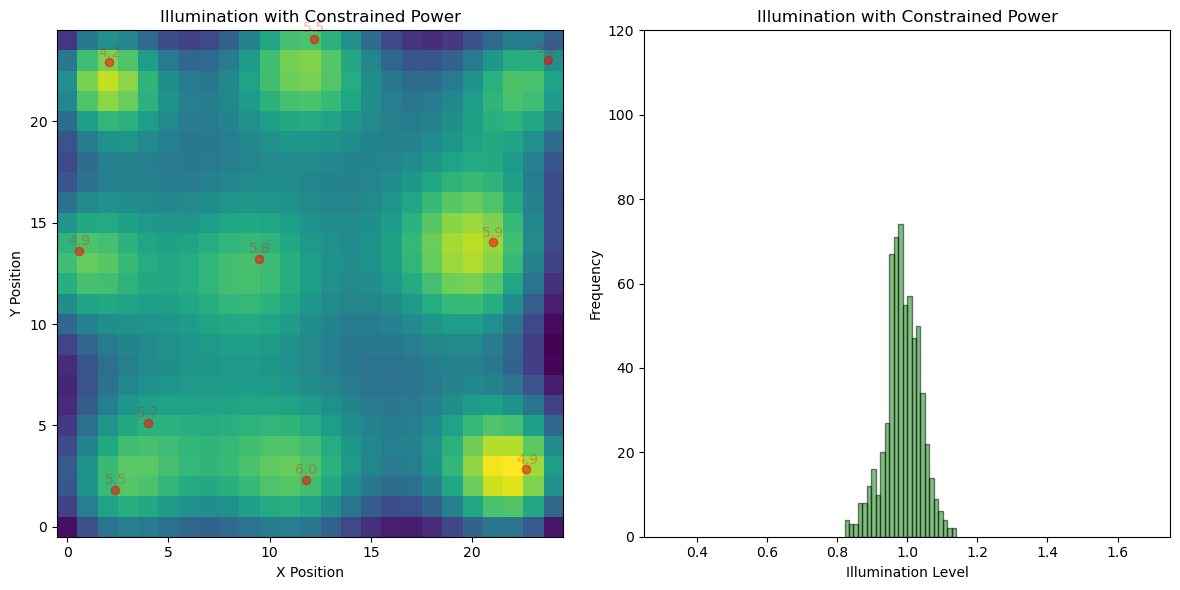

In [17]:
data = np.load('lamp_positions_and_cost.npz')
lamp_positions = data['positions']
cost = data['cost']

# New luminocity and RMSE
lamp_positions = lamp_positions.reshape(10,3)
# Calculate distances and A matrix as before
distances = cdist(pixel_positions, lamp_positions, metric='euclidean')
A = 1 / distances**2
scaler = 1 / np.mean(np.sum(A, axis=1))
A = A * scaler
# Solve for optimal lamp powers with cvxpy
p_new = cp.Variable(N)
objective = cp.Minimize(cp.norm(A @ p_new - l_des, 2))
constraints = [cp.sum(p_new) == 10, p_new >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

l_new = A @ p_new.value
rmse_p_new = np.sqrt(np.mean((l_new - l_des)**2))
print(f" RMSE with optimized lamp positions: \n{rmse_p_new}")

# Prepare luminocity for plot
l_new_grid = l_new.reshape(25, 25)

# Create subplot layout
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for fixed power level at 1
cax1 = ax[0].imshow(l_new_grid, cmap='viridis', origin='lower')
ax[0].scatter(lamp_positions[:, 0], lamp_positions[:, 1], c='red', marker='o', alpha=0.5, label='Lamp Positions')
ax[0].set_title('Illumination with Constrained Power')
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')

# Histogram for illumination values with optimized lamp powers
ax[1].hist(l_new, bins=25, color='green', alpha=0.5, edgecolor='black')
ax[1].set_title('Illumination with Constrained Power')
ax[1].set_xlabel('Illumination Level')
ax[1].set_ylabel('Frequency')
ax[1].set_ylim(0, 120)
ax[1].set_xlim(0.25, 1.75)

for lamp_pos in lamp_positions:
    lamp_pos = lamp_pos.round(1)
    # For the plot with fixed power level
    ax[0].text(lamp_pos[0], lamp_pos[1]+0.5, str(lamp_pos[2]), color='red', alpha=0.3, ha='center', va='center')

plt.tight_layout()
plt.show()